# 📊 Análisis Exploratorio de Datos (EDA) - Comentarios Tóxicos de YouTube

Este notebook contiene el análisis exploratorio de datos para el proyecto de detección de comentarios de odio en YouTube.

## 📋 Objetivos del EDA:
 - Explorar la estructura y calidad de los datos
 - Analizar la distribución de las diferentes categorías de toxicidad
 - Identificar patrones en los comentarios tóxicos vs no tóxicos
 - Detectar posibles desequilibrios en las clases
 - Análisis de texto: longitud, palabras más frecuentes, etc.
 - Identificar insights para el preprocesamiento y modelado

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga y Exploración Inicial de los Datos

In [3]:
df = pd.read_csv('../data/youtoxic_english_1000.csv')

print("🔍 INFORMACIÓN BÁSICA DEL DATASET")
print("="*50)
print(f"📊 Forma del dataset: {df.shape}")
print(f"📝 Número de comentarios: {df.shape[0]:,}")
print(f"🏷️ Número de características: {df.shape[1]}")

🔍 INFORMACIÓN BÁSICA DEL DATASET
📊 Forma del dataset: (1000, 15)
📝 Número de comentarios: 1,000
🏷️ Número de características: 15


In [4]:
print("\n📋 PRIMERAS 5 FILAS DEL DATASET:")
print("="*50)
df.head()


📋 PRIMERAS 5 FILAS DEL DATASET:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
print("\n📊 INFORMACIÓN GENERAL:")
print("="*50)
df.info()


📊 INFORMACIÓN GENERAL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


In [6]:
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
print("="*50)
df.describe()


📈 ESTADÍSTICAS DESCRIPTIVAS:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,Ugg2KwwX0V8-aXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


## 2. Análisis de las Etiquetas de Toxicidad

In [7]:
# Identificar las columnas de etiquetas (excluyendo metadatos y columnas con información insuficiente)
label_columns = [col for col in df.columns if col not in ['CommentId', 'VideoId', 'Text', 'index']]

# Identificar etiquetas con datos insuficientes para análisis
insufficient_labels = []
for col in label_columns:
    true_count = (df[col] == True).sum()
    if true_count <= 1:  # Menos de 2 casos positivos
        insufficient_labels.append(col)

# Filtrar etiquetas con datos suficientes para análisis
analysis_labels = [col for col in label_columns if col not in insufficient_labels]

print(f"🔍 Etiquetas identificadas: {label_columns}")
print(f"🔍 Etiquetas con datos insuficientes (≤1 casos): {insufficient_labels}")
print(f"🔍 Etiquetas para análisis: {analysis_labels}")
print(f"🔍 Total de etiquetas para análisis: {len(analysis_labels)}")

🔍 Etiquetas identificadas: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']
🔍 Etiquetas con datos insuficientes (≤1 casos): ['IsSexist', 'IsHomophobic', 'IsRadicalism']
🔍 Etiquetas para análisis: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsReligiousHate']
🔍 Total de etiquetas para análisis: 9


In [8]:
# Análisis de distribución de cada etiqueta
print("\n📊 DISTRIBUCIÓN DE ETIQUETAS:")
print("="*50)

label_stats = {}
for col in label_columns:
    true_count = (df[col] == True).sum()
    false_count = (df[col] == False).sum()
    true_pct = (true_count / len(df)) * 100
    
    label_stats[col] = {
        'True': true_count,
        'False': false_count,
        'True_pct': true_pct
    }
    
    print(f"{col}:")
    print(f"  ✅ True: {true_count:,} ({true_pct:.2f}%)")
    print(f"  ❌ False: {false_count:,} ({100-true_pct:.2f}%)")
    print()

if insufficient_labels:
    print("⚠️ ETIQUETAS EXCLUIDAS DEL ANÁLISIS:")
    print("="*50)
    for col in insufficient_labels:
        true_count = (df[col] == True).sum()
        print(f"{col}: Solo {true_count} caso(s) positivo(s) - Insuficiente para análisis")



📊 DISTRIBUCIÓN DE ETIQUETAS:
IsToxic:
  ✅ True: 462 (46.20%)
  ❌ False: 538 (53.80%)

IsAbusive:
  ✅ True: 353 (35.30%)
  ❌ False: 647 (64.70%)

IsThreat:
  ✅ True: 21 (2.10%)
  ❌ False: 979 (97.90%)

IsProvocative:
  ✅ True: 161 (16.10%)
  ❌ False: 839 (83.90%)

IsObscene:
  ✅ True: 100 (10.00%)
  ❌ False: 900 (90.00%)

IsHatespeech:
  ✅ True: 138 (13.80%)
  ❌ False: 862 (86.20%)

IsRacist:
  ✅ True: 125 (12.50%)
  ❌ False: 875 (87.50%)

IsNationalist:
  ✅ True: 8 (0.80%)
  ❌ False: 992 (99.20%)

IsSexist:
  ✅ True: 1 (0.10%)
  ❌ False: 999 (99.90%)

IsHomophobic:
  ✅ True: 0 (0.00%)
  ❌ False: 1,000 (100.00%)

IsReligiousHate:
  ✅ True: 12 (1.20%)
  ❌ False: 988 (98.80%)

IsRadicalism:
  ✅ True: 0 (0.00%)
  ❌ False: 1,000 (100.00%)

⚠️ ETIQUETAS EXCLUIDAS DEL ANÁLISIS:
IsSexist: Solo 1 caso(s) positivo(s) - Insuficiente para análisis
IsHomophobic: Solo 0 caso(s) positivo(s) - Insuficiente para análisis
IsRadicalism: Solo 0 caso(s) positivo(s) - Insuficiente para análisis


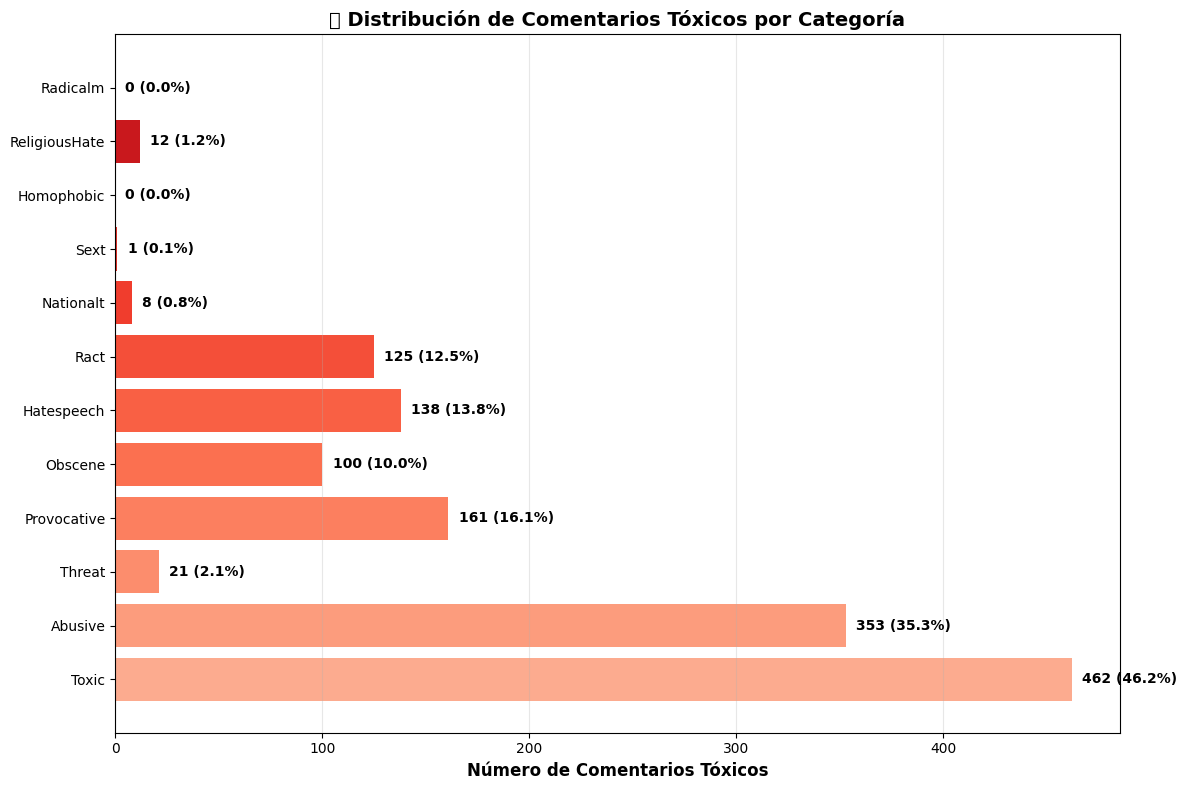

In [9]:
# Crear un gráfico de barras horizontal para mejor visualización
plt.figure(figsize=(12, 8))

# Preparar datos para el gráfico
labels = []
true_counts = []
percentages = []

for col in label_columns:
    labels.append(col.replace('Is', '').replace('is', ''))
    true_count = (df[col] == True).sum()
    true_counts.append(true_count)
    percentages.append((true_count / len(df)) * 100)

# Crear gráfico de barras horizontal
bars = plt.barh(labels, true_counts, color=plt.cm.Reds(np.linspace(0.3, 0.8, len(labels))))

# Añadir etiquetas con porcentajes
for i, (count, pct) in enumerate(zip(true_counts, percentages)):
    plt.text(count + 5, i, f'{count} ({pct:.1f}%)', 
             va='center', fontweight='bold', fontsize=10)

plt.xlabel('Número de Comentarios Tóxicos', fontsize=12, fontweight='bold')
plt.title('📊 Distribución de Comentarios Tóxicos por Categoría', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Análisis de Correlaciones entre Etiquetas

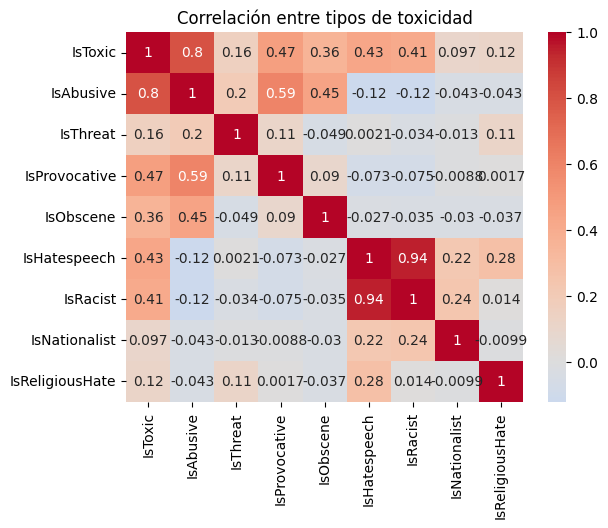

In [19]:
# Matriz de correlación entre etiquetas
correlation_matrix = df[analysis_labels].corr()

# Visualizar matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre tipos de toxicidad")
plt.show()

In [11]:
# Identificar correlaciones más altas
print("🔗 CORRELACIONES MÁS ALTAS:")
print("="*50)

# Obtener correlaciones sin la diagonal
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Label1': correlation_matrix.columns[i],
            'Label2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

# Ordenar por correlación absoluta
corr_df = pd.DataFrame(corr_pairs)
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("Top 10 correlaciones más fuertes:")
for _, row in corr_df.head(10).iterrows():
    print(f"  {row['Label1']} ↔ {row['Label2']}: {row['Correlation']:.3f}")

🔗 CORRELACIONES MÁS ALTAS:
Top 10 correlaciones más fuertes:
  IsHatespeech ↔ IsRacist: 0.945
  IsToxic ↔ IsAbusive: 0.797
  IsAbusive ↔ IsProvocative: 0.593
  IsToxic ↔ IsProvocative: 0.473
  IsAbusive ↔ IsObscene: 0.451
  IsToxic ↔ IsHatespeech: 0.432
  IsToxic ↔ IsRacist: 0.408
  IsToxic ↔ IsObscene: 0.360
  IsHatespeech ↔ IsReligiousHate: 0.275
  IsRacist ↔ IsNationalist: 0.238


## 4. Análisis de Texto

In [12]:
# Análisis básico de longitud de texto
print("📝 ANÁLISIS DE LONGITUD DE COMENTARIOS:")
print("="*50)

# Calcular estadísticas de longitud
df['text_length'] = df['Text'].str.len()
df['word_count'] = df['Text'].str.split().str.len()

print("Estadísticas de longitud de caracteres:")
print(df['text_length'].describe())
print("\nEstadísticas de número de palabras:")
print(df['word_count'].describe())

📝 ANÁLISIS DE LONGITUD DE COMENTARIOS:
Estadísticas de longitud de caracteres:
count    1000.000000
mean      185.554000
std       270.780777
min         3.000000
25%        47.000000
50%       101.000000
75%       217.000000
max      4421.000000
Name: text_length, dtype: float64

Estadísticas de número de palabras:
count    1000.000000
mean       33.776000
std        49.069498
min         1.000000
25%         9.000000
50%        19.000000
75%        39.000000
max       815.000000
Name: word_count, dtype: float64


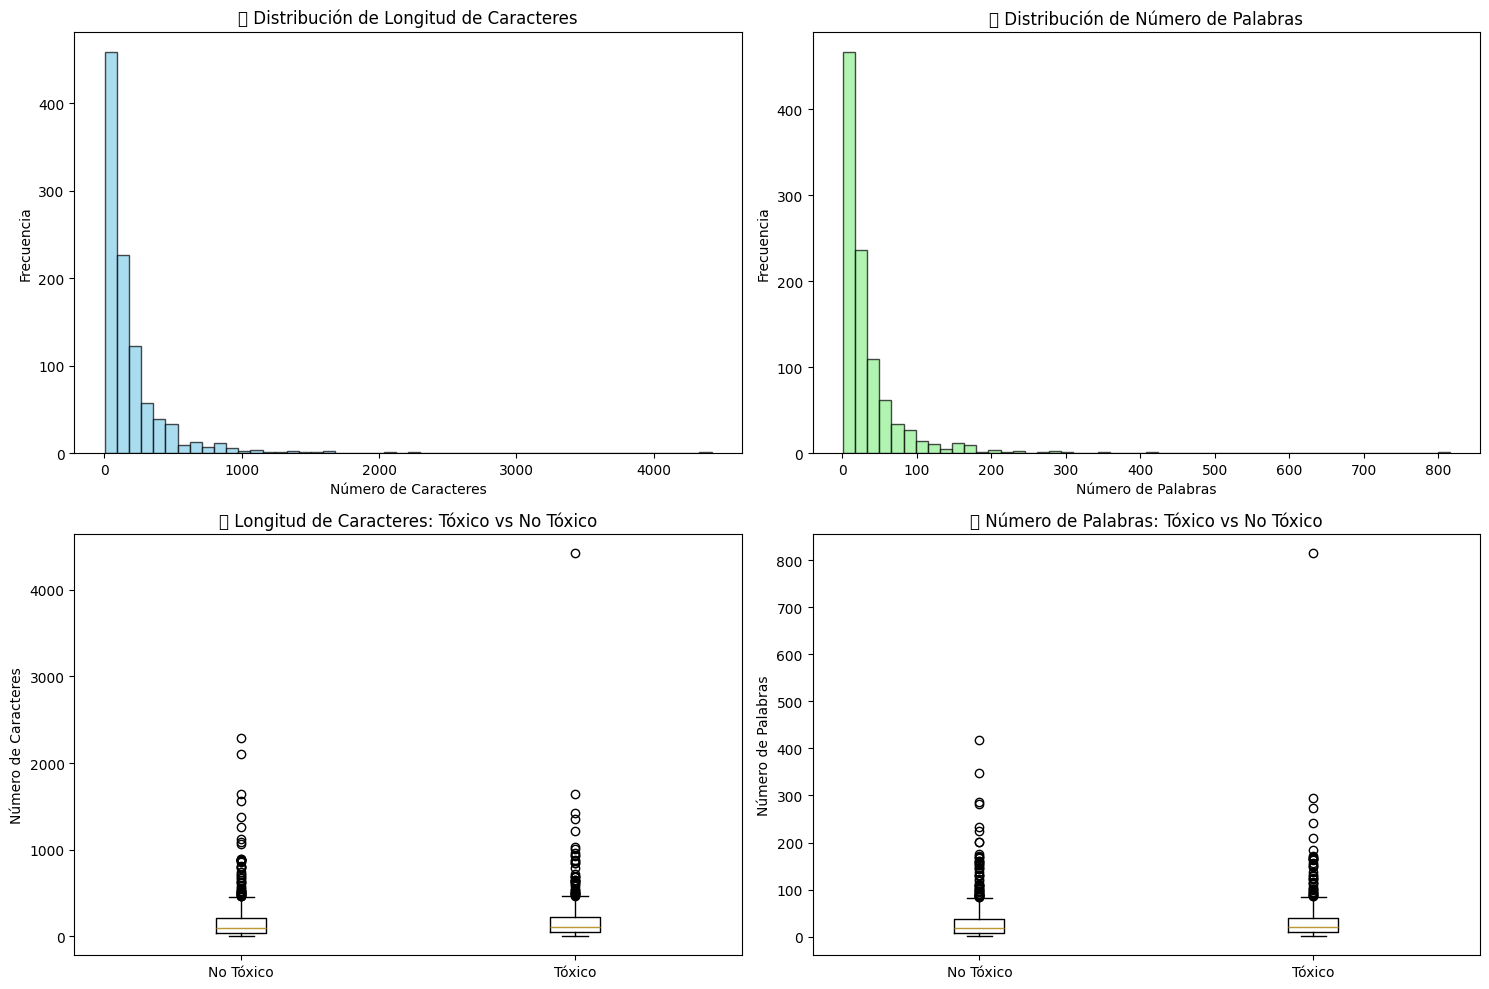

In [13]:
# Visualización de distribución de longitudes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de longitud de caracteres
axes[0,0].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('📏 Distribución de Longitud de Caracteres')
axes[0,0].set_xlabel('Número de Caracteres')
axes[0,0].set_ylabel('Frecuencia')

# Distribución de número de palabras
axes[0,1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('📝 Distribución de Número de Palabras')
axes[0,1].set_xlabel('Número de Palabras')
axes[0,1].set_ylabel('Frecuencia')

# Boxplot de longitud por toxicidad general
# Crear una columna de toxicidad general (si cualquier etiqueta es True)
df['is_toxic'] = df[analysis_labels].any(axis=1)

axes[1,0].boxplot([df[df['is_toxic'] == False]['text_length'], 
                   df[df['is_toxic'] == True]['text_length']], 
                  labels=['No Tóxico', 'Tóxico'])
axes[1,0].set_title('📊 Longitud de Caracteres: Tóxico vs No Tóxico')
axes[1,0].set_ylabel('Número de Caracteres')

# Boxplot de palabras por toxicidad general
axes[1,1].boxplot([df[df['is_toxic'] == False]['word_count'], 
                   df[df['is_toxic'] == True]['word_count']], 
                  labels=['No Tóxico', 'Tóxico'])
axes[1,1].set_title('📊 Número de Palabras: Tóxico vs No Tóxico')
axes[1,1].set_ylabel('Número de Palabras')

plt.tight_layout()
plt.show()

In [14]:
# Análisis de palabras más frecuentes
from collections import Counter
import re

def clean_text_for_analysis(text):
    """Limpia el texto para análisis de frecuencia"""
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

print("🔤 ANÁLISIS DE PALABRAS MÁS FRECUENTES:")
print("="*50)

# Palabras más frecuentes en comentarios no tóxicos
non_toxic_texts = df[df['is_toxic'] == False]['Text'].fillna('')
non_toxic_words = []
for text in non_toxic_texts:
    non_toxic_words.extend(clean_text_for_analysis(text).split())

# Palabras más frecuentes en comentarios tóxicos
toxic_texts = df[df['is_toxic'] == True]['Text'].fillna('')
toxic_words = []
for text in toxic_texts:
    toxic_words.extend(clean_text_for_analysis(text).split())

# Filtrar palabras vacías comunes
common_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their', 'this', 'that', 'these', 'those'}

non_toxic_words = [word for word in non_toxic_words if word not in common_stopwords and len(word) > 2]
toxic_words = [word for word in toxic_words if word not in common_stopwords and len(word) > 2]

print("Top 15 palabras en comentarios NO TÓXICOS:")
non_toxic_freq = Counter(non_toxic_words).most_common(15)
for word, count in non_toxic_freq:
    print(f"  {word}: {count}")

print("\nTop 15 palabras en comentarios TÓXICOS:")
toxic_freq = Counter(toxic_words).most_common(15)
for word, count in toxic_freq:
    print(f"  {word}: {count}")


🔤 ANÁLISIS DE PALABRAS MÁS FRECUENTES:
Top 15 palabras en comentarios NO TÓXICOS:
  not: 146
  people: 129
  black: 116
  all: 105
  police: 103
  what: 78
  just: 77
  like: 76
  about: 74
  there: 73
  get: 64
  out: 60
  officer: 59
  white: 59
  video: 58

Top 15 palabras en comentarios TÓXICOS:
  black: 130
  people: 127
  all: 103
  not: 87
  get: 79
  what: 77
  white: 76
  like: 75
  just: 74
  police: 72
  dont: 57
  who: 54
  when: 52
  brown: 50
  fuck: 50


## 5. Análisis de Desequilibrio de Clases

In [15]:
print("⚖️ ANÁLISIS DE DESEQUILIBRIO DE CLASES:")
print("="*50)

# Análisis general de toxicidad
toxic_count = df['is_toxic'].sum()
non_toxic_count = len(df) - toxic_count
toxic_ratio = toxic_count / len(df)

print(f"📊 Comentarios tóxicos: {toxic_count:,} ({toxic_ratio:.2%})")
print(f"📊 Comentarios no tóxicos: {non_toxic_count:,} ({1-toxic_ratio:.2%})")
print(f"📊 Ratio de desequilibrio: {non_toxic_count/toxic_count:.2f}:1")

# Análisis por cada etiqueta (solo las que se van a usar)
print("\n🔍 Desequilibrio por etiqueta (solo etiquetas válidas para análisis):")
for col in analysis_labels:
    positive_count = (df[col] == True).sum()
    negative_count = (df[col] == False).sum()
    ratio = negative_count / positive_count if positive_count > 0 else float('inf')
    print(f"  {col}: {ratio:.2f}:1 (False:True)")

⚖️ ANÁLISIS DE DESEQUILIBRIO DE CLASES:
📊 Comentarios tóxicos: 462 (46.20%)
📊 Comentarios no tóxicos: 538 (53.80%)
📊 Ratio de desequilibrio: 1.16:1

🔍 Desequilibrio por etiqueta (solo etiquetas válidas para análisis):
  IsToxic: 1.16:1 (False:True)
  IsAbusive: 1.83:1 (False:True)
  IsThreat: 46.62:1 (False:True)
  IsProvocative: 5.21:1 (False:True)
  IsObscene: 9.00:1 (False:True)
  IsHatespeech: 6.25:1 (False:True)
  IsRacist: 7.00:1 (False:True)
  IsNationalist: 124.00:1 (False:True)
  IsReligiousHate: 82.33:1 (False:True)


## 6. 🔍 Análisis de Comentarios Multi-etiqueta

In [16]:
print("🏷️ ANÁLISIS DE COMENTARIOS MULTI-ETIQUETA:")
print("="*50)

# Contar cuántas etiquetas positivas tiene cada comentario
df['num_toxic_labels'] = df[analysis_labels].sum(axis=1)

# Distribución de número de etiquetas por comentario
label_distribution = df['num_toxic_labels'].value_counts().sort_index()
print("Distribución de número de etiquetas tóxicas por comentario:")
for num_labels, count in label_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"  {num_labels} etiquetas: {count:,} comentarios ({percentage:.2f}%)")

🏷️ ANÁLISIS DE COMENTARIOS MULTI-ETIQUETA:
Distribución de número de etiquetas tóxicas por comentario:
  0 etiquetas: 538 comentarios (53.80%)
  2 etiquetas: 100 comentarios (10.00%)
  3 etiquetas: 294 comentarios (29.40%)
  4 etiquetas: 48 comentarios (4.80%)
  5 etiquetas: 14 comentarios (1.40%)
  6 etiquetas: 6 comentarios (0.60%)


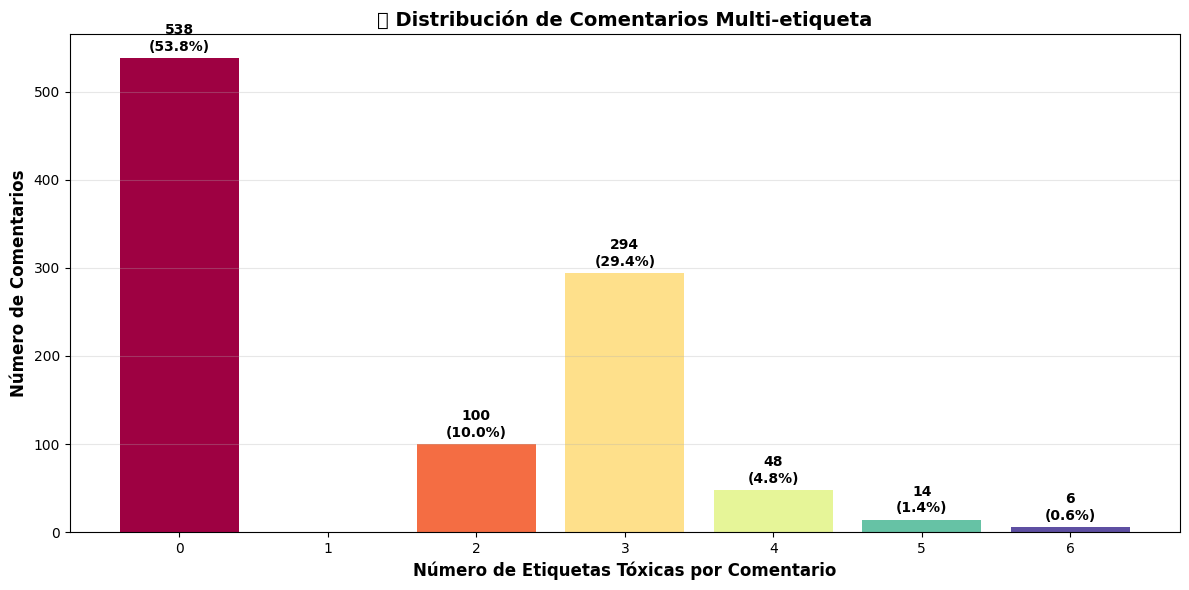

In [17]:
# Visualización de comentarios multi-etiqueta
plt.figure(figsize=(12, 6))

# Gráfico de barras
bars = plt.bar(label_distribution.index, label_distribution.values, 
               color=plt.cm.Spectral(np.linspace(0, 1, len(label_distribution))))

# Añadir etiquetas con porcentajes
for bar, count in zip(bars, label_distribution.values):
    height = bar.get_height()
    percentage = (count / len(df)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Número de Etiquetas Tóxicas por Comentario', fontsize=12, fontweight='bold')
plt.ylabel('Número de Comentarios', fontsize=12, fontweight='bold')
plt.title('🏷️ Distribución de Comentarios Multi-etiqueta', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Resumen de Insights y Recomendaciones

In [18]:
print("🔍 INSIGHTS PRINCIPALES DEL EDA:")
print("="*60)

print("\n🔍 1. ESTRUCTURA DE DATOS:")
print(f"   • Dataset con {len(df):,} comentarios y {len(analysis_labels)} etiquetas de toxicidad válidas")
print(f"   • Etiquetas válidas: {', '.join(analysis_labels)}")
if insufficient_labels:
    print(f"   • Etiquetas excluidas por datos insuficientes: {', '.join(insufficient_labels)}")

print("\n⚖️ 2. DESEQUILIBRIO DE CLASES:")
print(f"   • {toxic_ratio:.1%} de comentarios son tóxicos en general")
print("   • Todas las etiquetas muestran fuerte desequilibrio (mayoría de casos negativos)")
print("   • Esto requerirá técnicas de balanceamiento o métricas especiales")

print("\n🔍 3. CORRELACIONES:")
if len(corr_df) > 0:
    strongest_corr = corr_df.iloc[0]
    print(f"   • Correlación más fuerte: {strongest_corr['Label1']} ↔ {strongest_corr['Label2']} ({strongest_corr['Correlation']:.3f})")
print("   • Algunas etiquetas están correlacionadas, considerar esto en el modelado")

print("\n🔍 4. CARACTERÍSTICAS DEL TEXTO:")
print(f"   • Longitud promedio: {df['text_length'].mean():.0f} caracteres")
print(f"   • Número promedio de palabras: {df['word_count'].mean():.1f}")
multi_label_pct = (df['num_toxic_labels'] > 1).sum() / len(df) * 100
print(f"   • {multi_label_pct:.1f}% de comentarios tóxicos tienen múltiples etiquetas")

print("\n🔍 5. RECOMENDACIONES PARA EL MODELADO:")
print("   • Usar métricas apropiadas para datos desequilibrados (F1, ROC-AUC, Precision-Recall)")
print("   • Considerar técnicas de balanceamiento (SMOTE, class_weight, etc.)")
print("   • Implementar validación estratificada")
print("   • Evaluar modelos multi-etiqueta vs binarios independientes")
print("   • Preprocesar texto: lowercasing, eliminación de caracteres especiales, etc.")
print("   • Considerar features de longitud de texto como variables adicionales")
if insufficient_labels:
    print(f"   • Excluir del modelado las etiquetas: {', '.join(insufficient_labels)} por falta de datos")

# Guardar algunas estadísticas clave para uso posterior
stats_summary = {
    'total_comments': len(df),
    'toxic_ratio': toxic_ratio,
    'valid_label_columns': analysis_labels,
    'excluded_labels': insufficient_labels,
    'avg_text_length': df['text_length'].mean(),
    'avg_word_count': df['word_count'].mean(),
    'multi_label_ratio': multi_label_pct / 100
}

print(f"\n🔍 Estadísticas guardadas para referencia futura:")
for key, value in stats_summary.items():
    print(f"   {key}: {value}")

print("\n🔍 EDA COMPLETADO - Listo para la fase de preprocesamiento y modelado! 🔍")

🔍 INSIGHTS PRINCIPALES DEL EDA:

🔍 1. ESTRUCTURA DE DATOS:
   • Dataset con 1,000 comentarios y 9 etiquetas de toxicidad válidas
   • Etiquetas válidas: IsToxic, IsAbusive, IsThreat, IsProvocative, IsObscene, IsHatespeech, IsRacist, IsNationalist, IsReligiousHate
   • Etiquetas excluidas por datos insuficientes: IsSexist, IsHomophobic, IsRadicalism

⚖️ 2. DESEQUILIBRIO DE CLASES:
   • 46.2% de comentarios son tóxicos en general
   • Todas las etiquetas muestran fuerte desequilibrio (mayoría de casos negativos)
   • Esto requerirá técnicas de balanceamiento o métricas especiales

🔍 3. CORRELACIONES:
   • Correlación más fuerte: IsHatespeech ↔ IsRacist (0.945)
   • Algunas etiquetas están correlacionadas, considerar esto en el modelado

🔍 4. CARACTERÍSTICAS DEL TEXTO:
   • Longitud promedio: 186 caracteres
   • Número promedio de palabras: 33.8
   • 46.2% de comentarios tóxicos tienen múltiples etiquetas

🔍 5. RECOMENDACIONES PARA EL MODELADO:
   • Usar métricas apropiadas para datos des